![Image of Yaktocat](https://cupy.chainer.org/images/cupy_logo.png)


# CuPy library for GPU acceleration

CuPy is an implementation of NumPy-compatible multi-dimensional array on CUDA. CuPy consists of cupy.ndarray, the core multi-dimensional array class, and many functions on it. It supports a subset of numpy.ndarray interface.


Let's import few useful libraries...

In [1]:
import time
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
!nvidia-smi 

Tue May 05 11:34:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.50       Driver Version: 442.50       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX          WDDM  | 00000000:65:00.0  On |                  N/A |
| 41%   35C    P8    13W / 280W |   1075MiB / 24576MiB |     14%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!nvidia-smi --list-gpus

GPU 0: TITAN RTX (UUID: GPU-abe18baa-9b5c-1d6b-c84c-06d8ce0dad35)


### Array creation on the GPU memory
CuPy has a concept of the current device, which is the default device on which the allocation, manipulation, calculation etc. of arrays are taken place. Suppose the ID of current device is 0. The following code allocates array contents on GPU 0 but raises an error when calling the non-existing device 1. 

In [9]:
with cp.cuda.Device(0):
    x_on_gpu0 = cp.array([1, 2, 3, 4, 5])

In [10]:
with cp.cuda.Device(1):
    x_on_gpu1 = cp.array([1, 2, 3, 4, 5])  # raises error if we do not have a second GPU

CUDARuntimeError: cudaErrorInvalidDevice: invalid device ordinal

### Move array from CPU memory to GPU memory
First we create a random array using numpy.random.rand, then we move it to the GPU memory.

In [40]:
dimension = 128
x = np.random.rand(dimension,dimension)

# moving the array to GPU
x_gpu = cp.asarray(x)

print(x_gpu)

[[0.68177128 0.15810749 0.73887168 ... 0.09216155 0.11799998 0.47317676]
 [0.21933412 0.85704002 0.10737799 ... 0.19692049 0.07148979 0.32274793]
 [0.65713525 0.89903785 0.34716306 ... 0.60412771 0.76173712 0.65378806]
 ...
 [0.71887339 0.47473624 0.50602295 ... 0.19650952 0.48896017 0.75569175]
 [0.61571907 0.79621009 0.74519924 ... 0.30767064 0.98022181 0.68020303]
 [0.59003054 0.07561232 0.96623947 ... 0.15678095 0.62381471 0.22202501]]


We can now observe that x_gpu array is an istance of a cupy object.

In [41]:
cp.get_array_module(x_gpu)

<module 'cupy' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\cupy\\__init__.py'>

### Move array back from GPU memory to CPU memory
There are two ways to bring back an array on the CPU memory. For plotting, we need to have the variable on the CPU RAM. otherwise python will rise an error.

<IPython.core.display.Javascript object>


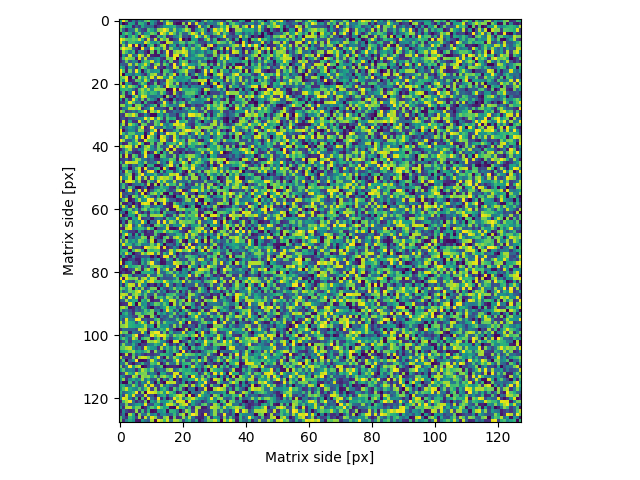

In [18]:
# first method
x_cpu = cp.asnumpy(x_gpu)

# second method - same result
x_cpu = x_gpu.get()

plt.figure(1)
plt.imshow(x_cpu)
plt.xlabel('Matrix side [px]'), plt.ylabel('Matrix side [px]')
plt.tight_layout()

## Performance comparison: 2D matrix FFT 

Here we test the FFT performance on arrays from side 0 to 1024.

In [19]:
dimensions = np.arange(1,1025)

performance_fft_cpu = np.zeros(len(dimensions))
performance_fft_gpu = np.zeros(len(dimensions))

First we run it on the CPU, by calling the 1D function *np.fft.fft*.

In [26]:
for dimension in dimensions:
    # start timing
    start_time = time.time()

    # functions to execute
    x = np.random.rand(dimension, dimension)
    x_fft = np.fft.fft2(x)
    
    # end timing
    performance_fft_cpu[dimension-1] = (time.time() - start_time)
    
    del x, x_fft

Then, we run it on the GPU, by calling the 1D function *cp.fft.fft*.

In [27]:
for dimension in dimensions:
    # start timing
    start_time = time.time()
    
    # functions to execute
    x_gpu = cp.random.rand(dimension,dimension)
    x_gpu_fft = cp.fft.fft2(x_gpu)
    cp.cuda.Stream.null.synchronize()

    # end timing
    performance_fft_gpu[dimension-1] = (time.time() - start_time)
    
    del x_gpu, x_gpu_fft

Plot the performance results.

<IPython.core.display.Javascript object>


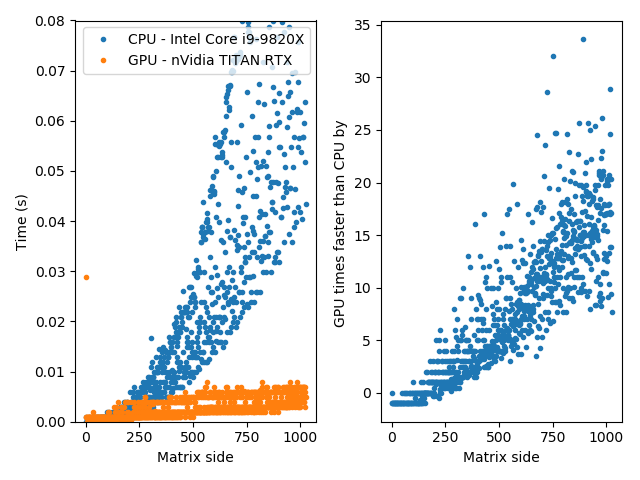

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [28]:
plt.figure(2)
plt.subplot(121)
plt.plot(dimensions,performance_fft_cpu, '.')
plt.plot(dimensions,performance_fft_gpu, '.')
plt.legend(('CPU - Intel Core i9-9820X', 'GPU - nVidia TITAN RTX'))
plt.xlabel('Matrix side'), plt.ylabel('Time (s)')
plt.ylim([0, 0.08])

plt.subplot(122)
plt.plot(dimensions,(performance_fft_cpu-performance_fft_gpu)/performance_fft_gpu, '.')
plt.xlabel('Matrix side'), plt.ylabel('GPU times faster than CPU by ')

plt.tight_layout()

<IPython.core.display.Javascript object>


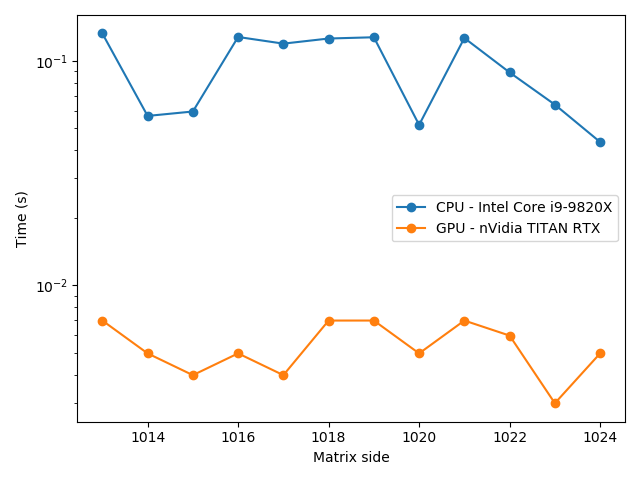

In [29]:
plt.figure(3)
plt.plot(dimensions[1012:1024],performance_fft_cpu[1012:1024], 'o-')
plt.plot(dimensions[1012:1024],performance_fft_gpu[1012:1024], 'o-')
plt.legend(('CPU - Intel Core i9-9820X', 'GPU - nVidia TITAN RTX'))
plt.xlabel('Matrix side'), plt.ylabel('Time (s)')
plt.yscale('log')
plt.tight_layout()

## Performance comparison: 3D volumes of size powers of 2 (and similar)

Here we test the performance on a similar problem but running the FFT only on dimensions that are powers of 2.

In [30]:
dimensions = [8,12,16,24,32,48,64,96,128,192,256,384,512]

performance_fftn_cpu = np.zeros(len(dimensions))
performance_fftn_gpu = np.zeros(len(dimensions))

Run on the CPU:

In [31]:
numIteration = 10
count=0

for dimension in dimensions:
    # start average timing
    start_time = time.time()

    # functions to execute
    for iteration in range(numIteration):
        x = np.random.rand(dimension, dimension, dimension)
        x_fft = np.fft.fftn(x)
    
    # end average timing
    performance_fftn_cpu[count] = (time.time() - start_time)/numIteration
    count+=1
    del x, x_fft

Run on the GPU:

In [35]:
numIteration = 10
count=0

for dimension in dimensions:
    # start average timing
    start_time = time.time()

    # functions to execute
    for iteration in range(numIteration):
        x_gpu = cp.random.rand(dimension, dimension, dimension)
        x_gpu_fft = cp.fft.fftn(x_gpu)
        cp.cuda.Stream.null.synchronize()

    # end average timing
    performance_fftn_gpu[count] = (time.time() - start_time)/numIteration
    count+=1
    del x_gpu, x_gpu_fft

Let's plot the results...

<IPython.core.display.Javascript object>


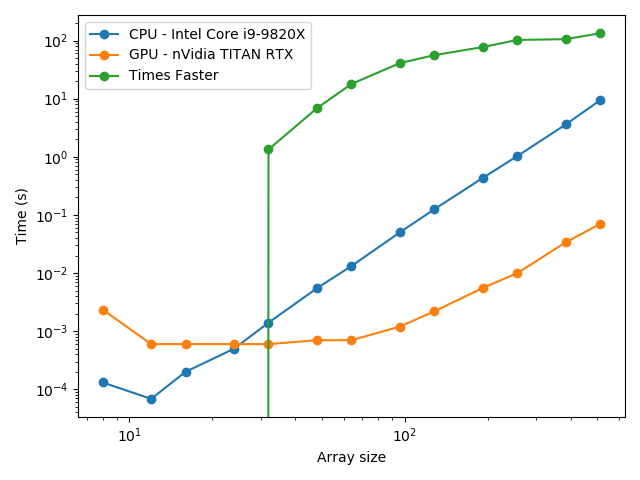

In [36]:
plt.figure(4)
plt.plot(dimensions,performance_fftn_cpu, 'o-')
plt.plot(dimensions,performance_fftn_gpu, 'o-')
plt.legend(('CPU - Intel Core i9-9820X', 'GPU - nVidia TITAN RTX'))
plt.xlabel('Array size'), plt.ylabel('Time (s)')
plt.yscale('log'), plt.xscale('log')
plt.tight_layout()

In [37]:
plt.figure(4)
plt.plot(dimensions,(performance_fftn_cpu-performance_fftn_gpu)/performance_fftn_gpu, 'o-')
plt.legend(('CPU - Intel Core i9-9820X', 'GPU - nVidia TITAN RTX', 'Times Faster'))
plt.xlabel('Array size'), plt.ylabel('Time (s)')
plt.tight_layout()

## Comparison Table

List of functions implemented in cupy/numpy:
https://docs-cupy.chainer.org/en/stable/reference/comparison.html

## Agnostic Coding
The compatibility of CuPy with NumPy enables us to write CPU/GPU generic code. It can be made easy by the cupy.get_array_module() function. This function returns the numpy or cupy module based on arguments. A CPU/GPU generic function is defined using it like follows:


We generate two arrays, one in the CPU and another on the GPU

In [38]:
sz = 256
center, side = int(sz/2), int(sz/4)

y_cpu = np.random.rand(sz,sz)
y_gpu = cp.random.rand(sz,sz)

Then we define a function, that we force to be agnostic by calling cp.get_array_module(array) that returns the module in which array is defined. From that moment, this module is assigned to the aliax 'xp' and it is interchangeable between Numpy/Cupy functions that share the same sintax.

In [42]:
def specklePattern(array, radius=[18,20]):
    # define the xp module by looking on the module property of the array passed in the function
    xp = cp.get_array_module(array)

    # some operations done within the function with the agnostic call to xp library
    w, h = array.shape
    center = (int(w/2), int(h/2))
    Y, X = xp.ogrid[:h, :w]
    dist_from_center = xp.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask1 = (dist_from_center <= radius[0])
    mask2 = (dist_from_center <= radius[1])    
    mask = xp.bitwise_xor(mask1, mask2)
    
    return array*mask, xp.abs((xp.fft.fftn(xp.fft.ifftshift(array*mask))))

We run the function above by passing a **NumPy ndarray** in its argument 

<IPython.core.display.Javascript object>


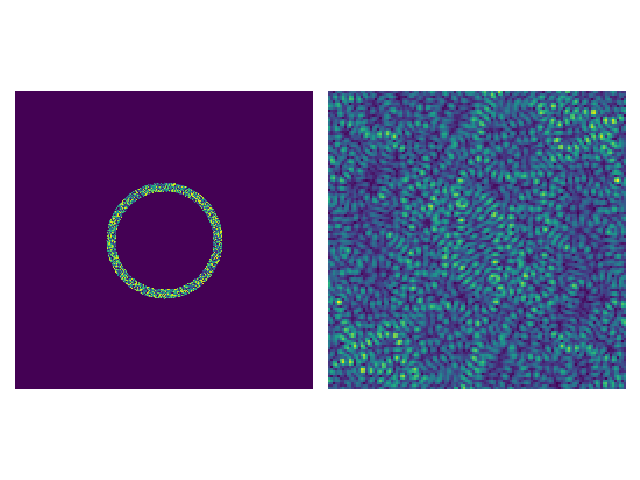

In [43]:
mask, speckle = specklePattern(y_cpu, radius=[42,50])

plt.figure(5)
plt.subplot(121), plt.imshow(mask), plt.axis('off')
plt.subplot(122), plt.imshow(speckle[center-side:center+side,center-side:center+side]), plt.axis('off')
plt.tight_layout()

Same as above, but here we run the function by passing a **CuPy ndarray** in its argument. 

<IPython.core.display.Javascript object>


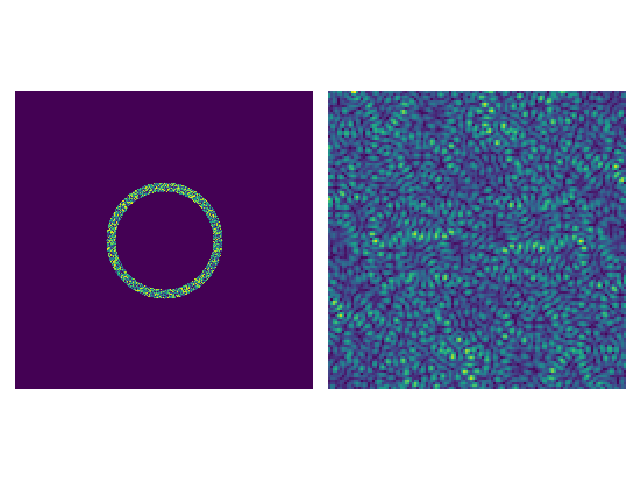

In [44]:
mask_gpu, speckle_gpu = specklePattern(y_gpu, radius=[42,50])

plt.figure(6)
plt.subplot(121), plt.imshow(mask_gpu.get()), plt.axis('off')
plt.subplot(122), plt.imshow(speckle_gpu[center-side:center+side,center-side:center+side].get()), plt.axis('off')
plt.tight_layout()

## Is always better the usage of the GPU?
Here we try to explicitly make the performance of the GPU worse that doing the full operation on the CPU. First we define the array that store the timing performance

In [45]:
dimensions = [8,12,16,24,32,48,64,96,128,192,256,384,512]
dimensions = 2**np.arange(6,15)

performance_sum_cpu = np.zeros(len(dimensions))
performance_sum_gpu1 = np.zeros(len(dimensions))
performance_sum_gpu2 = np.zeros(len(dimensions))

We decide to compute the sum of a 2D array generated on the CPU memory by using the .sum() attribute.

In [46]:
numIteration = 10
count=0
for dimension in dimensions:
    start_time = time.time()
    
    for iteration in range(numIteration):
        x = np.random.rand(dimension, dimension)

        # function to be computed
        x_cpu_sum = x.sum()

    performance_sum_cpu[count] = (time.time() - start_time)
    count+=1
    del x, x_cpu_sum

Now, let's imagine that we **need** to handle an array on the CPU memory (for example in case we have to read this array from a file somewhere in the HDD, we couldn't load it directly to GPU memory). Will it be convenient to pass it every time to the GPU to process it faster?

In [47]:
numIteration = 10
count=0
for dimension in dimensions:
    start_time = time.time()

    for iteration in range(numIteration):
        # we generate the array on the CPU memory, then we move it to the GPU
        x = np.random.rand(dimension, dimension)
        x_gpu = cp.asarray(x)
        
        # function to be computed
        x_gpu_sum = x_gpu.sum()        
        cp.cuda.Stream.null.synchronize()

    performance_sum_gpu1[count] = (time.time() - start_time)
    count+=1
    del x, x_gpu_sum

Of course, if we do everything **directly** on the GPU it will be again faster than the previous case. 

In [48]:
numIteration = 10
count=0
for dimension in dimensions:
    start_time = time.time()

    for iteration in range(numIteration):
        # we generate the array on the CPU memory, then we move it to the GPU
        x_gpu = cp.random.rand(dimension, dimension)
        
        # function to be computed
        x_gpu_sum = x_gpu.sum()        
        cp.cuda.Stream.null.synchronize()

    performance_sum_gpu2[count] = (time.time() - start_time)
    count+=1
    del x_gpu, x_gpu_sum

Plot the results, focusing on the percent speed loss or gain. 

<IPython.core.display.Javascript object>


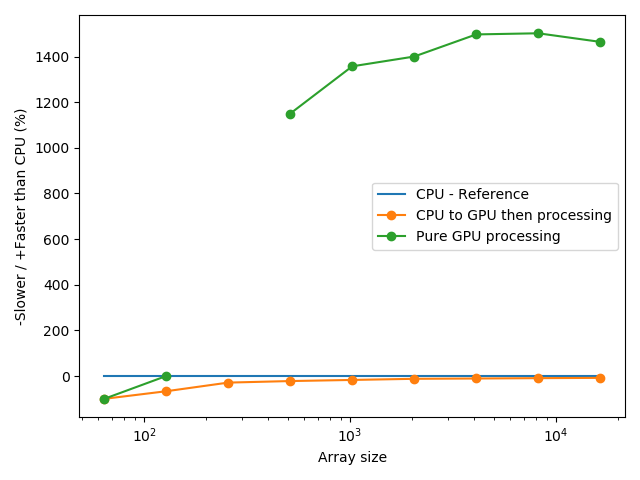

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [50]:
plt.figure(7)
plt.plot([dimensions[0],dimensions[-1]], [0, 0])
plt.plot(dimensions,(performance_sum_cpu-performance_sum_gpu1)/performance_sum_gpu1*100, 'o-')
plt.plot(dimensions,(performance_sum_cpu-performance_sum_gpu2)/performance_sum_gpu2*100, 'o-')
plt.legend(('CPU - Reference', 'CPU to GPU then processing', 'Pure GPU processing'))
plt.xlabel('Array size'), plt.ylabel('-Slower / +Faster than CPU (%)')
plt.xscale('log')
plt.tight_layout()